In [1]:
import sys
import shutil
import time
import resource
import json
from pathlib import Path

from scipy.stats import multivariate_normal, norm

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, Callback
#from keras.metrics import AUC, RootMeanSquaredError
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import r2_score, auc, roc_curve, roc_auc_score, log_loss, fbeta_score,precision_recall_curve, mean_squared_error, mean_absolute_error

import nn_models as nnm
import dataprocessing as dp
import visualization as viz

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class HyperANNAutoencoder(kt.HyperModel):
    def __init__(self, num_input_features):
        super(HyperANNAutoencoder, self).__init__()
        self.num_input = num_input_features

    def build(self, hp):
        hp_units_1 = hp.Int('outer-layer', min_value=32, max_value=64, step=4)
        hp_units_2 = hp.Int('middle-layer', min_value=12, max_value=28, step=4)
        hp_units_3 = hp.Int('inner-layer', min_value=4, max_value=8, step=2)
        
#         self.encoder = tf.keras.Sequential([
#           tf.keras.layers.Dense(hp_units_1, activation="relu"),
#           tf.keras.layers.Dense(hp_units_2, activation="relu"),
#           tf.keras.layers.Dense(hp_units_3, activation="relu")])

#         self.decoder = tf.keras.Sequential([
#           tf.keras.layers.Dense(hp_units_2, activation="relu"),
#           tf.keras.layers.Dense(hp_units_1, activation="relu"),
#           tf.keras.layers.Dense(self.num_input, activation="linear")])
        
        model = tf.keras.Sequential([
            # Encoder
            tf.keras.layers.Dense(hp_units_1, activation="relu"),
            tf.keras.layers.Dense(hp_units_2, activation="relu"),
            tf.keras.layers.Dense(hp_units_3, activation="relu"),
            # Decoder
            tf.keras.layers.Dense(hp_units_2, activation="relu"),
            tf.keras.layers.Dense(hp_units_1, activation="relu"),
            tf.keras.layers.Dense(self.num_input, activation="linear")
        ])
        
        # Tune the learning rate
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-6, 1e-3])
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                            loss='mean_squared_error')
        return model

#     def call(self, x, hp):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
        
#         # Tune the learning rate
#         hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-3])

#         decoded.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                             loss='mean_squared_error')
#         return decoded

In [3]:
class HyperLSTMAutoEncoder(kt.HyperModel):
    def __init__(self, timesteps, num_inputs):
        super(HyperLSTMAutoEncoder, self).__init__()
        self.timesteps  = timesteps
        self.num_inputs = num_inputs
        
    def build(self, hp):
        
        hp_units = hp.Int('outer-layer', min_value=28, max_value=64, step=4)
        model = tf.keras.Sequential([
            # Encoder
            tf.keras.layers.LSTM(hp_units, return_sequences = False),
            # Code layer
            tf.keras.layers.RepeatVector(self.timesteps),
            # Decoder
            tf.keras.layers.LSTM(hp_units, return_sequences = True),
            # TimeDistributed layer
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.num_inputs))
            
        ])
        
        # Tune the learning rate
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-6, 1e-3])
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                            loss='mean_squared_error')
        
        return model

In [4]:
class AnomalyDetector(Model):
    def __init__(self, num_input_features):
        super(AnomalyDetector, self).__init__()
        self.num_input = num_input_features

        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(16, activation="relu"),
          tf.keras.layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Dense(16, activation="relu"),
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(self.num_input, activation="linear")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
### Test running the model
loss = 'mean_squared_error'
TIME_STEPS = 24
BATCH_SIZE = 128
num_features = 1

### Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')


In [6]:
### Load the data ###
# data, varnames, target = dp.load_data_nn('3-jk', sensor='left', dlh=0, 
#                                          keep_SH=False, return_target=True, smote=None)

In [30]:
# ### Load the data - LSTM indv
# data, target = dp.create_featured_dataset('3-jk', sensor='left', 
#                                           dlh=0, keep_SH=False, keep_event=True, smote=None)

In [31]:
### Load the data - general
data, target, holdout_data, holdout_target = \
    dp.load_general_data_lstm('3-jk', sensor='left', dlh=0, keep_SH=False, keep_event=True, smote=None)

['1-sf', '10-rc', '12-mb', '17-sb', '19-me', '2-bd', '22-ap', '26-tc', '31-ns', '32-rf', '36-af', '38-cs', '39-dg', '4-rs', '41-pk', '43-cm', '7-sb']
The beginning shape is:  (9902, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (8112, 99)
NaN values in this dataset:  False
The left data frame set shape is:  (8112, 48)
The right data frame set shape is:  (8112, 48)
The keep left data frame set shape is:  (8112, 24)
The keep right data frame set shape is:  (8112, 24)
Not adding fake positive data samples.
Index(['t25_l', 't26_l', 't27_l', 't28_l', 't29_l', 't30_l', 't31_l', 't32_l',
       't33_l', 't34_l', 't35_l', 't36_l', 't37_l', 't38_l', 't39_l', 't40_l',
       't41_l', 't42_l', 't43_l', 't44_l', 't45_l', 't46_l', 't47_l', 't48_l'],
      dtype='object')
Index(['t25_r', 't26_r', 't27_r', 't28_r', 't29_r', 't30_r', 't31_r', 't32_r',
       't33_r', 't34_r', 't35_r', 't36_r', 't37_r', 't38_r', 't39_r', 't40_r',
       't41_r', 't42_r', 't43_r', 't44_r', 't4

The beginning shape is:  (8525, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (6367, 99)
NaN values in this dataset:  False
The left data frame set shape is:  (6367, 48)
The right data frame set shape is:  (6367, 48)
The keep left data frame set shape is:  (6367, 24)
The keep right data frame set shape is:  (6367, 24)
Not adding fake positive data samples.
Index(['t25_l', 't26_l', 't27_l', 't28_l', 't29_l', 't30_l', 't31_l', 't32_l',
       't33_l', 't34_l', 't35_l', 't36_l', 't37_l', 't38_l', 't39_l', 't40_l',
       't41_l', 't42_l', 't43_l', 't44_l', 't45_l', 't46_l', 't47_l', 't48_l'],
      dtype='object')
Index(['t25_r', 't26_r', 't27_r', 't28_r', 't29_r', 't30_r', 't31_r', 't32_r',
       't33_r', 't34_r', 't35_r', 't36_r', 't37_r', 't38_r', 't39_r', 't40_r',
       't41_r', 't42_r', 't43_r', 't44_r', 't45_r', 't46_r', 't47_r', 't48_r'],
      dtype='object')
The size of the dataset for 32-rf is (6367, 24, 1)
The size of the target for 32-rf is (6367,)

In [32]:
data.shape

(88126, 24, 1)

In [9]:
#ndata = np.reshape(data, (data.shape[0], data.shape[1], 1))

In [33]:
### Split the data into train, val, and testing
target = np.where(target == 1, 1, 0)

train_idx, val_idx, test_idx = dp.split_data_cv_indx(data,target)

# Prepare data for the autoencoder model
normal, anomalous = dp.process_autoencoder(data[train_idx], data[test_idx], data[val_idx],
                                           target[train_idx], target[test_idx], target[val_idx])

normal_train, normal_val, normal_train_target, normal_val_target             = normal
anomalous_train, anomalous_val, anomalous_train_target, anomalous_val_target = anomalous

# Try Normalizing the data
#scaled_normal_train, scaled_test, scaled_normal_val = dp.normalize_data(normal_train, data[test_idx], normal_val)

train_data = normal_train # scaled_normal_train #
y_train    = normal_train_target

test_data  = data[test_idx] #scaled_test #
y_test     = target[test_idx]

val_data   = normal_val #scaled_normal_val #
y_val      = normal_val_target

print("Anomalous train data shape is: ", anomalous_train.shape)
print("Anomalous val data shape is: ", anomalous_val.shape)

Train labels shape:  (47596,)
Test labels shape:  (13804,)
Val labels shape:  (26726,)
Normal train data shape is:  (47467, 24, 1)
Normal test data shape is:  (13761, 24, 1)
Normal val data shape is:  (26683, 24, 1)
Anomalous train data shape is:  (129, 24, 1)
Anomalous test data shape is:  (43, 24, 1)
Anomalous val data shape is:  (43, 24, 1)
Anomalous train data shape is:  (129, 24, 1)
Anomalous val data shape is:  (43, 24, 1)


In [53]:
# Test Hypertuning
tuner = kt.Hyperband(HyperLSTMAutoEncoder(24, 1), #HyperANNAutoencoder(24),
                        objective=kt.Objective(name='val_loss', direction='min'),
                        max_epochs=100,
                        factor=10,
                        seed = 8476823,
                        overwrite=False,
                        directory='TEST_HYPER_GENERAL_LSTM')#,
                        #project_name=project_name)

INFO:tensorflow:Reloading Oracle from existing project TEST_HYPER_GENERAL_LSTM/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from TEST_HYPER_GENERAL_LSTM/untitled_project/tuner0.json


In [54]:
tuner.search(train_data, train_data, epochs=100, validation_data = (val_data, y_val), batch_size=BATCH_SIZE)

INFO:tensorflow:Oracle triggered exit


In [55]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("The best hyperparameters are: ", best_hps.values)

The best hyperparameters are:  {'outer-layer': 60, 'learning_rate': 0.001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}


In [57]:
autoencoder = tuner.hypermodel.build(best_hps)

history = autoencoder.fit(train_data, train_data, epochs=100, batch_size=BATCH_SIZE,
                        validation_data = (val_data, val_data))

Epoch 1/100
371/371 [==============================] - 41s 97ms/step - loss: 18552.0820 - val_loss: 16494.0000
Epoch 2/100
371/371 [==============================] - 31s 83ms/step - loss: 13609.3584 - val_loss: 12351.5625
Epoch 3/100
371/371 [==============================] - 34s 92ms/step - loss: 10209.2441 - val_loss: 9339.3291
Epoch 4/100
371/371 [==============================] - 23s 63ms/step - loss: 7787.8120 - val_loss: 7203.7451
Epoch 5/100
371/371 [==============================] - 25s 69ms/step - loss: 6130.5635 - val_loss: 5757.0713
Epoch 6/100
371/371 [==============================] - 29s 79ms/step - loss: 5059.7974 - val_loss: 4831.5073
Epoch 7/100
371/371 [==============================] - 26s 70ms/step - loss: 4419.7090 - val_loss: 4281.4653
Epoch 8/100
371/371 [==============================] - 31s 83ms/step - loss: 4075.7883 - val_loss: 3986.9866
Epoch 9/100
371/371 [==============================] - 27s 73ms/step - loss: 3913.5376 - val_loss: 3842.8174
Epoch 10/100
3

371/371 [==============================] - 25s 68ms/step - loss: 3820.4104 - val_loss: 3733.2246
Epoch 76/100
371/371 [==============================] - 19s 51ms/step - loss: 3820.5273 - val_loss: 3734.9390
Epoch 77/100
371/371 [==============================] - 24s 66ms/step - loss: 3820.4250 - val_loss: 3734.8533
Epoch 78/100
371/371 [==============================] - 34s 92ms/step - loss: 3820.5378 - val_loss: 3732.2292
Epoch 79/100
371/371 [==============================] - 18s 49ms/step - loss: 3820.4119 - val_loss: 3735.9241
Epoch 80/100
371/371 [==============================] - 23s 62ms/step - loss: 3820.3896 - val_loss: 3734.5735
Epoch 81/100
371/371 [==============================] - 20s 54ms/step - loss: 3820.5173 - val_loss: 3736.1399
Epoch 82/100
371/371 [==============================] - 21s 57ms/step - loss: 3820.4495 - val_loss: 3735.3372
Epoch 83/100
371/371 [==============================] - 26s 71ms/step - loss: 3820.4482 - val_loss: 3734.9485
Epoch 84/100
371/371 [=

In [ ]:
# Test single model
autoencoder = HyperANNAutoencoder(2)#AnomalyDetector(48) #, timesteps) #nnm.AnomalyDetector(data.shape[1])

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='mean_squared_error')
                    #metrics=[tf.keras.metrics.Precision(name='precision'),
                    #                tf.keras.metrics.Recall(name='recall'),
                    #                tf.keras.metrics.AUC(name='auc'),
                    #                tf.keras.metrics.AUC(name='prc', curve='PR')])

history = autoencoder.fit(train_data, train_data,
          epochs=15000, callbacks = [early_stopping],
          validation_split=0.2, batch_size=BATCH_SIZE)
          #validation_data=(val_data, val_data))

<AxesSubplot:title={'center':'ANN Autoencoder'}, xlabel='Epochs', ylabel='Loss'>

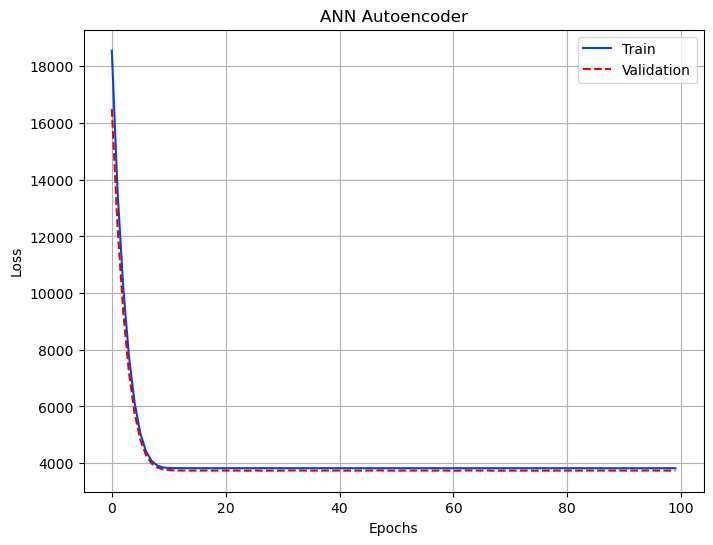

In [58]:
# Plot Train and Val loss
viz.plot_loss(history.history['loss'], history.history['val_loss'], title = 'ANN Autoencoder')

In [59]:
### Test the MAE and R^2 of the train, val and test datasets for the autoencoder
train_reconstructions = autoencoder.predict(train_data, BATCH_SIZE)
val_reconstructions   = autoencoder.predict(val_data, BATCH_SIZE)
test_reconstructions  = autoencoder.predict(test_data, BATCH_SIZE)

108/108 [==============================] - 5s 47ms/step


In [60]:
train_reconstructions.shape

(47467, 24, 1)

In [61]:
train_data.shape

(47467, 24, 1)

In [43]:
# Get the Mean RMSE values for each dataset
# Calculate the mean MAE and R^2 for each dataset
train_mae_list = []
train_r2_list  = []
train_rmse_list = []
for tri in range(train_data.shape[0]):
    train_mae = mean_absolute_error(train_data[tri], train_reconstructions[tri,:])
    train_r2  = r2_score(train_data[tri], train_reconstructions[tri,:])
    train_rmse = np.sqrt(mean_squared_error(train_data[tri], train_reconstructions[tri,:]))
    
    train_mae_list.append(train_mae)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    
test_mae_list  = []
test_r2_list   = []
test_rmse_list = []
for tei in range(test_data.shape[0]):
    test_mae = mean_absolute_error(test_data[tei], test_reconstructions[tei,:])
    test_r2  = r2_score(test_data[tei], test_reconstructions[tei,:])
    test_rmse = np.sqrt(mean_squared_error(test_data[tei], test_reconstructions[tei,:]))
    
    test_mae_list.append(test_mae)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)

val_mae_list   = []
val_r2_list    = []
val_rmse_list  = []
for vi in range(val_data.shape[0]):
    val_mae = mean_absolute_error(val_data[vi], val_reconstructions[vi,:])
    val_r2  = r2_score(val_data[vi], val_reconstructions[vi,:])
    val_rmse = np.sqrt(mean_squared_error(val_data[vi], val_reconstructions[vi,:]))
    
    val_mae_list.append(val_mae)
    val_r2_list.append(val_r2)
    val_rmse_list.append(val_rmse)

In [44]:
# Print the Mean MAE and R^2
print("Train MAE: ", np.mean(train_mae_list))
print("Val MAE: ", np.mean(val_mae_list))
print("Test MAE: ", np.mean(test_mae_list))
print("-"*40)
print("Train R-squared: ", np.mean(train_r2_list))
print("Val R-squared: ", np.mean(val_r2_list))
print("Test R-squared: ", np.mean(test_r2_list))
print("-"*40)
print("Train RMSE: ", np.mean(train_rmse_list))
print("Val RMSE: ", np.mean(val_rmse_list))
print("Test RMSE: ", np.mean(test_rmse_list))

Train MAE:  11.053620106740116
Val MAE:  11.309327575320795
Test MAE:  8.053821998911056
----------------------------------------
Train R-squared:  -5.875744239131119e+24
Val R-squared:  -7.411992104813831e+24
Test R-squared:  -1.5470335584537294e+25
----------------------------------------
Train RMSE:  14.075869837409412
Val RMSE:  14.337068102094479
Test RMSE:  10.07234227447812


In [45]:
### Plot the traces for Train, Test, Val ###
import matplotlib.pyplot as plt
import seaborn as sns

def legend_without_duplicate_labels(ax):
    '''https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib'''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def plot_traces(real_data, reconstructions, dataset='Train'):
    
    fig, ax = plt.subplots()

    pdx = np.random.choice(range(real_data.shape[0]), size = 1)

    ax.plot(real_data[pdx, :24].T, label = f'{dataset} True - Left', linestyle='-', color = 'xkcd:orange')
    #ax.plot(real_data[pdx, 24:].T, label = f'{dataset} True - Right', linestyle='-', color = 'xkcd:red')

    ax.plot(reconstructions[pdx, :24].T, label = f'{dataset} Predictions - Left', linestyle='--', color = 'xkcd:blue')
    #ax.plot(reconstructions[pdx, 24:].T, label = f'{dataset} Predictions - Right', linestyle='--', color = 'xkcd:black')
    
    ax.set_title(f'{dataset} Traces')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Glucose')
    
    legend_without_duplicate_labels(ax)
    return ax

In [46]:
def plot_lstm_traces(real_data, reconstructions, dataset='Train'):
    
    fig, ax = plt.subplots()

    pdx = np.random.choice(range(real_data.shape[0]), size = 1)

    ax.plot(real_data[pdx, :, 0].T, label = f'{dataset} True - Left', linestyle='-', color = 'xkcd:orange')
#     ax.plot(real_data[pdx, :, 1].T, label = f'{dataset} True - Right', linestyle='-', color = 'xkcd:red')

    ax.plot(reconstructions[pdx, :, 0].T, label = f'{dataset} Predictions - Left', linestyle='--', color = 'xkcd:blue')
#     ax.plot(reconstructions[pdx, :, 1].T, label = f'{dataset} Predictions - Right', linestyle='--', color = 'xkcd:black')
    
    ax.set_title(f'{dataset} Traces')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Glucose')
    
    legend_without_duplicate_labels(ax)
    return ax

In [47]:
# # Train #
# plot_traces(train_data, train_reconstructions)

# # Test #
# plot_traces(test_data, test_reconstructions, 'Test')

# # Validation #
# plot_traces(val_data, val_reconstructions, 'Val')

<AxesSubplot:title={'center':'Val Traces'}, xlabel='Time Points', ylabel='Glucose'>

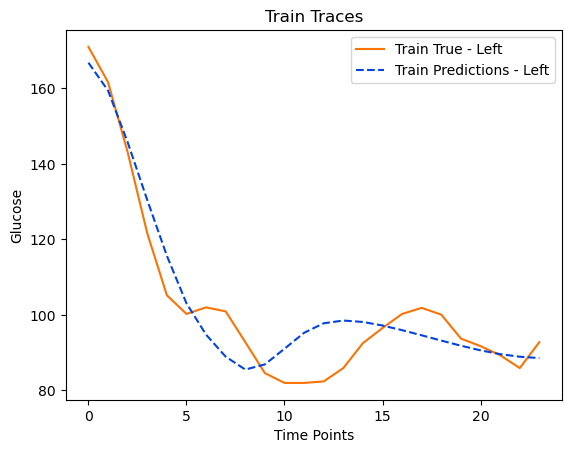

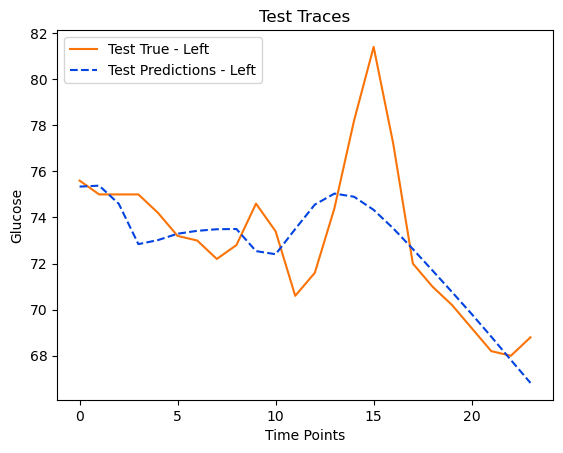

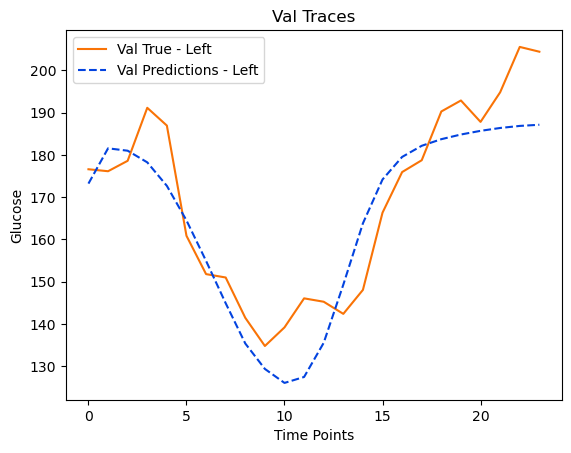

In [50]:
# Train #
plot_lstm_traces(train_data, train_reconstructions)

# Test #
plot_lstm_traces(test_data, test_reconstructions, 'Test')

# Validation #
plot_lstm_traces(val_data, val_reconstructions, 'Val')

## Try Classification via Thresholding

In [27]:
class ThresholdEstimator:

    def __init__(self) -> None:
        self.mu        = 0
        self.sigma     = 1
        self.threshold = None

    def fit(self, model, data, target):

        # Reconstruct the data
        reconstructions = model.predict(data)
        print("Reconstructions:")
        print(reconstructions[:5, :5])
        print("Data:")
        print(data[:5, :5])
        if len(data.shape) == 3:
            errors = tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data))
        else:
            errors = tf.keras.losses.mse(reconstructions, data)
        
        # Estimate the normal distribution of the errors
        self.mu    = np.mean(errors, axis = 0)
        self.sigma = np.cov(errors)

        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        likelihoods  = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        print("Likelihoods:")
        print(likelihoods[:5])

        f_list = []
        
        #step_size = int((max(likelihoods) - min(likelihoods)) / 1000) # Too small for arange
        thresholds = np.linspace(min(likelihoods), max(likelihoods), 100)
        
        for t in thresholds:

            preds = (likelihoods<t).astype(int)
            f = fbeta_score(target, preds, beta=0.1)
            f_list.append(f)

        bidx = np.argmax(f_list)
        self.best_threshold = thresholds[bidx]
        #self.best_threshold = np.max(errors)
        #self.best_threshold = np.quantile(errors, 0.95) #thresholds[bidx]

        return self
    
    def _compress_array(self, array):
        compressed_array = [array[sample, array.shape[1]-1, :] for sample in range(array.shape[0])]
    
        return compressed_array
    
    def predict(self, model, data, target):
        
        reconstructions = model.predict(data)
        if len(data.shape) == 3:
            errors = np.array(tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data)))
        else:
            errors = np.array(tf.keras.losses.mse(reconstructions, data))
        print(errors[:5])
        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        #likelihoods = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        likelihoods = np.array(errors)
        print(likelihoods[:5])
        
        pred_labels = (likelihoods < self.best_threshold).astype(int)
        #likelihoods = errors
        #pred_labels = (errors > self.best_threshold).astype(int)
        return likelihoods, pred_labels

In [28]:
# Fit the threshold using the validation dataset.
ter = ThresholdEstimator()

ter.fit(autoencoder, val_data, y_val)

56/56 [==============================] - 1s 11ms/step
Reconstructions:
[[[102.79114 ]
  [ 96.799965]
  [ 88.88252 ]
  [ 82.22179 ]
  [ 75.87967 ]]

 [[ 91.58616 ]
  [ 87.4956  ]
  [ 80.73229 ]
  [ 75.00273 ]
  [ 69.29058 ]]

 [[ 80.81794 ]
  [ 79.4549  ]
  [ 74.30854 ]
  [ 69.45038 ]
  [ 64.54102 ]]

 [[ 76.46143 ]
  [ 75.408134]
  [ 70.12639 ]
  [ 64.87415 ]
  [ 60.250973]]

 [[ 72.83625 ]
  [ 71.01349 ]
  [ 64.93654 ]
  [ 59.20969 ]
  [ 55.33431 ]]]
Data:
[[[105.2]
  [ 97.8]
  [ 83.2]
  [ 76. ]
  [ 74.2]]

 [[ 97.8]
  [ 83.2]
  [ 76. ]
  [ 74.2]
  [ 68.4]]

 [[ 83.2]
  [ 76. ]
  [ 74.2]
  [ 68.4]
  [ 62.2]]

 [[ 76. ]
  [ 74.2]
  [ 68.4]
  [ 62.2]
  [ 58.6]]

 [[ 74.2]
  [ 68.4]
  [ 62.2]
  [ 58.6]
  [ 58. ]]]
Likelihoods:
[1.36960477e-07 1.36960477e-07 1.36960477e-07 1.36960477e-07
 1.36960477e-07]


/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [29]:
test_preds, test_labels = ter.predict(autoencoder, test_data, y_test)

fpr_test, tpr_test, thresh_test = roc_curve(y_test, test_preds)
ppr_test, rec_test, pthresh_test = precision_recall_curve(y_test, test_preds)

print("Test AU-ROC: ", auc(fpr_test, tpr_test))
print("Test AU-PRC: ", auc(rec_test, ppr_test))
print("F-0.1 Score: ", fbeta_score(y_test, test_labels, beta=0.1))

183/183 [==============================] - 2s 13ms/step
[ 72.06296453  55.62546529   7.33868591  87.48744578 146.61312796]
[ 72.06296453  55.62546529   7.33868591  87.48744578 146.61312796]
Test AU-ROC:  0.38048019688644685
Test AU-PRC:  0.0014946744205987825
F-0.1 Score:  0.0


In [68]:
# Recombine full train and val data for testing
full_train_data, full_y_train = data[train_idx], target[train_idx]
full_val_data,   full_y_val   = data[val_idx], target[val_idx]

In [69]:
# Predict Train data
train_preds, train_labels = ter.predict(autoencoder, full_train_data, full_y_train)

fpr_train, tpr_train, thresh_train  = roc_curve(full_y_train, train_preds)
ppr_train, rec_train, pthresh_train = precision_recall_curve(full_y_train, train_preds)

print("Test AU-ROC: ", auc(fpr_train, tpr_train))
print("Test AU-PRC: ", auc(rec_train, ppr_train))
print("F-0.1 Score: ", fbeta_score(full_y_train, train_labels, beta=0.1))

75/75 [==============================] - 0s 3ms/step
[171.86039923 129.63831902 147.84939159 196.38190948 232.23465913]
[171.86039923 129.63831902 147.84939159 196.38190948 232.23465913]
Test AU-ROC:  0.4354310082241852
Test AU-PRC:  0.011921589607301195
F-0.1 Score:  0.0


In [70]:
# Predict Validation data
val_preds, val_labels = ter.predict(autoencoder, full_val_data, full_y_val)

fpr_val, tpr_val, thresh_val  = roc_curve(full_y_val, val_preds)
ppr_val, rec_val, pthresh_val = precision_recall_curve(full_y_val, val_preds)

print("Validation AU-ROC: ", auc(fpr_val, tpr_val))
print("Validation AU-PRC: ", auc(rec_val, ppr_val))
print("F-0.1 Score: ", fbeta_score(full_y_val, val_labels, beta=0.1))

57/57 [==============================] - 0s 2ms/step
[180.60361516  78.24247373  47.13382588  25.06046097  20.5411027 ]
[180.60361516  78.24247373  47.13382588  25.06046097  20.5411027 ]
Validation AU-ROC:  0.47719199850439337
Validation AU-PRC:  0.006224502936759781
F-0.1 Score:  0.0


In [71]:
anomalous_val

array([[101.8       , 103.6       , 106.4       , 112.6       ,
        117.2       , 119.6       , 120.        , 117.6       ,
        111.4       , 109.2       , 110.6       , 107.        ,
        105.2       ,  97.8       ,  83.2       ,  76.        ,
         74.2       ,  68.4       ,  62.2       ,  58.6       ,
         58.        ,  56.4       ,  49.6       ,  41.6       ,
        132.        , 134.        , 137.        , 142.        ,
        147.        , 154.        , 160.        , 157.        ,
        156.        , 161.        , 159.        , 147.        ,
        134.        , 112.        ,  88.        ,  74.        ,
         68.        ,  73.        ,  83.        ,  78.        ,
         75.        ,  73.        ,  63.        ,  57.        ],
       [250.        , 232.6       , 210.4       , 194.        ,
        176.6       , 157.        , 138.6       , 125.4       ,
        119.8       , 116.6       , 112.8       , 108.8       ,
        102.4       ,  93.        ,  87